## Statistics (one Topic)

In [1]:
import os
import sys

# Needed to import modules from parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from collections import Counter
from datasets import load_from_disk, Dataset, ClassLabel, Value, Features, load_dataset
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import random
import torch

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
topic = "energie" #"energie" #"kinder" "cannabis"


In [4]:
dataset = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed")
print(dataset)
print(dataset[1])

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label'],
    num_rows: 52250
})
{'_id': '64a0946b749484eec84dbbae', 'batch_id': 16, 'domain': 'aida.de', 'view_url': 'aida.de/planen/ST10230921/kategorie/ShoreEx/tage/7/port/FRCEQ', 'lang': 'de', 'text': ' Warenkorb 0,00 â\x82¬ Wir bitten um einen Moment Geduld Impressum Datenschutz', 'text_length': 75, 'word_count': 12, 'topic': 'energie', 'category': 'other', 'good_for_training': 'False', 'good_for_augmentation': 'True', 'annotation_type': 'domain_discarded', 'is_topic': False, 'label': 0}


## Filter by Content Length

In [5]:
tokenizer = AutoTokenizer.from_pretrained("deepset/gbert-large")

In [6]:
def get_input_length(text):
    """ Tokenize the input text and return the number of tokens """
    return len(tokenizer.encode(text, add_special_tokens=True, truncation=False, padding=False))

print(get_input_length("Hello, my name is John Doe"))

12


In [7]:
def update_metrics(example):
    example['text_length'] = len(example['text'])
    example['word_count'] = len(example['text'].split())
    example['token_count'] = get_input_length(example['text'])
    return example

dataset = dataset.map(update_metrics)

In [8]:
token_counts = dataset["token_count"]

max_token_count = max(token_counts)
min_token_count = min(token_counts)
avg_token_count = sum(token_counts) / len(token_counts)
std_token_count = np.std(token_counts)  # Using numpy for standard deviation

print(f"Maximum token count: {max_token_count}")
print(f"Minimum token count: {min_token_count}")
print(f"Average token count: {avg_token_count}")
print(f"Standard deviation of token count: {std_token_count}")

Maximum token count: 391285
Minimum token count: 2
Average token count: 1412.1532057416268
Standard deviation of token count: 5155.331995978307


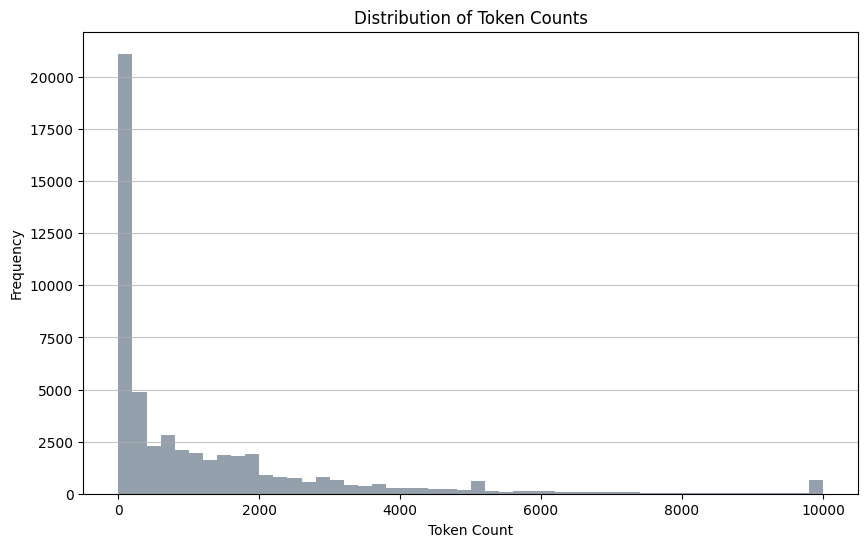

In [9]:
import matplotlib.pyplot as plt

# Plotting the distribution of token counts with a more muted color
plt.figure(figsize=(10, 6))
plt.hist([min(count, 10000) for count in token_counts], bins=50, alpha=0.75, color='slategray')
plt.title('Distribution of Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

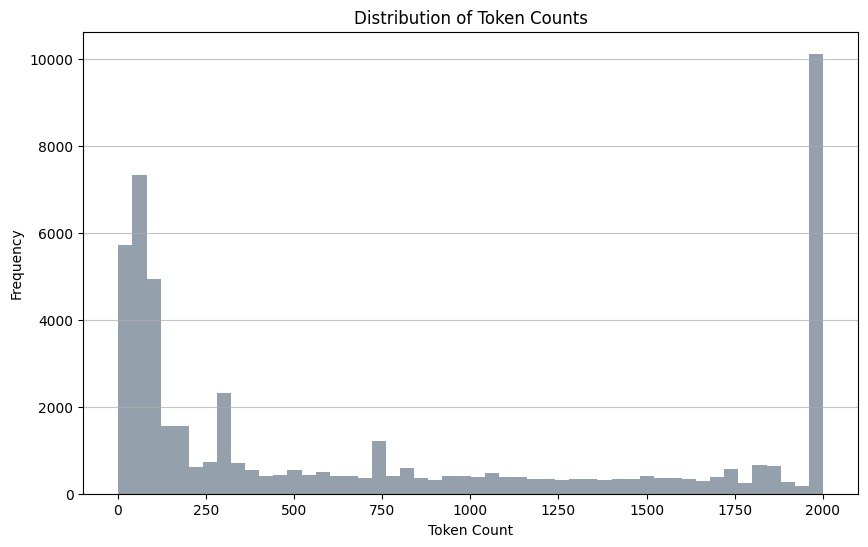

In [10]:
import matplotlib.pyplot as plt

# Plotting the distribution of token counts with a more muted color
plt.figure(figsize=(10, 6))
plt.hist([min(count, 2000) for count in token_counts], bins=50, alpha=0.75, color='slategray')
plt.title('Distribution of Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [11]:
import random
from pprint import pprint

def sample_and_print(dataset, n, m, sample_size=10):
    """
    Samples and pretty-prints examples from the dataset where the token count is between n and m.

    Parameters:
    - dataset: The dataset to sample from.
    - n: The lower bound of the token count range.
    - m: The upper bound of the token count range.
    - sample_size: The number of examples to sample and print. Default is 10.
    """
    
    # Ensure there's a 'token_count' column
    if 'token_count' not in dataset.column_names:
        raise ValueError("Dataset must contain a 'token_count' column.")
    
    # Filter the dataset for examples with token_count between n and m
    filtered_examples = [example for example in dataset if n <= example['token_count'] <= m]

    # Check if there are enough examples to sample
    if len(filtered_examples) < sample_size:
        print(f"Only {len(filtered_examples)} examples found with token count between {n} and {m}.")
        sample_size = len(filtered_examples)

    # Randomly sample examples from the filtered list
    sampled_examples = random.sample(filtered_examples, sample_size)

    # Pretty print the sampled examples
    for example in sampled_examples:
        pprint(example)
        print("-" * 80)  # Separator for readability


In [12]:
# n = 0  # Define the lower bound for token count
# m = 5  # Define the upper bound for token count

# # Call the function
# sample_and_print(dataset, n, m)


In [13]:
# Define your conditions
n = 10000  # Upper limit
m = 5   # Lower limit, assuming you actually meant m is less than n

# Filter the dataset
dataset = dataset.filter(lambda example: example['token_count'] > m and example['token_count'] < n)

## Filter by Language

In [14]:
lang_counts = Counter(dataset['lang'])
print("Lang frequencies:", lang_counts)

Lang frequencies: Counter({'de': 36053, 'en': 13923, 'nl': 236, 'ru': 200, 'sv': 155, 'it': 152, 'tl': 139, 'fr': 107, 'et': 107, 'hu': 91, 'ca': 60, 'es': 53, 'no': 43, 'af': 30, 'da': 20, 'ro': 17, 'pl': 15, 'ar': 11, 'lv': 10, 'cy': 9, 'pt': 7, 'sl': 4, 'tr': 3, 'cs': 3, 'el': 3, 'bg': 3, 'so': 2, 'zh-cn': 2, 'th': 2, 'vi': 2, 'ko': 2, 'fi': 1, 'ur': 1, 'uk': 1})


## Labels:

In [15]:
#dataset = dataset.filter(lambda example: example['lang'] == "de")

## Filter by Category

In [16]:
dataset = dataset.filter(lambda example: example['good_for_training'] == "True")

In [17]:
token_counts = dataset["token_count"]

max_token_count = max(token_counts)
min_token_count = min(token_counts)
avg_token_count = sum(token_counts) / len(token_counts)
std_token_count = np.std(token_counts)  # Using numpy for standard deviation

print(f"Maximum token count: {max_token_count}")
print(f"Minimum token count: {min_token_count}")
print(f"Average token count: {avg_token_count}")
print(f"Standard deviation of token count: {std_token_count}")

Maximum token count: 9987
Minimum token count: 8
Average token count: 1987.7011542497378
Standard deviation of token count: 1632.530675096132


In [18]:
# Count the occurrences of each label
label_counts = Counter(dataset['label'])
print("Class frequencies:", label_counts)

# Find the minimum count
min_count = min(label_counts.values())
print("Minimum class frequency:", min_count)

Class frequencies: Counter({0: 4529, 1: 236})
Minimum class frequency: 236
